# From the previous two models run for promblem statement 3, we look at the need for performing for one more model and carrying out further analysis for the problem.

### -Nikita Sharma

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
df = pd.read_csv("C:\\Users\\sniks\\Downloads\\dft-road-casualty-statistics-collision-2024.csv")

C:\Users\sniks\AppData\Local\Temp\ipykernel_18800\338067758.py:1: DtypeWarning: Columns (0,2,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\sniks\\Downloads\\dft-road-casualty-statistics-collision-2024.csv")


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report)
from xgboost import XGBClassifier

In [5]:
df["is_serious_or_fatal"] = df["collision_severity"].isin([1, 2]).astype(int)
y = df["is_serious_or_fatal"]

df["is_urban"] = (df["speed_limit"] <= 40).astype(int)
df["is_high_speed"] = (df["speed_limit"] >= 50).astype(int)
df["has_crossing"] = ((df["pedestrian_crossing_human_control_historic"] > 0) | (df["pedestrian_crossing_physical_facilities_historic"] > 0) | (df["pedestrian_crossing"] > 0)).astype(int)
df["has_traffic_control"] = (df["junction_control"] != "None").astype(int)

features = ["speed_limit","is_urban","is_high_speed", "has_crossing","has_traffic_control","number_of_vehicles"]

junction_cols = [c for c in df.columns if c.startswith("junction_detail_")]
road_cols = [c for c in df.columns if c.startswith("road_type_")]

X = df[features + junction_cols + road_cols]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(n_estimators=300, learning_rate=0.08, max_depth=6, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss")
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, probs)
best_thr = thr[np.argmax(tpr - fpr)]
y_pred = (probs >= best_thr).astype(int)

XGBoost MODEL
Best Threshold: 0.241
              precision    recall  f1-score   support

           0       0.81      0.57      0.67     15172
           1       0.31      0.59      0.41      5014

    accuracy                           0.58     20186
   macro avg       0.56      0.58      0.54     20186
weighted avg       0.69      0.58      0.61     20186



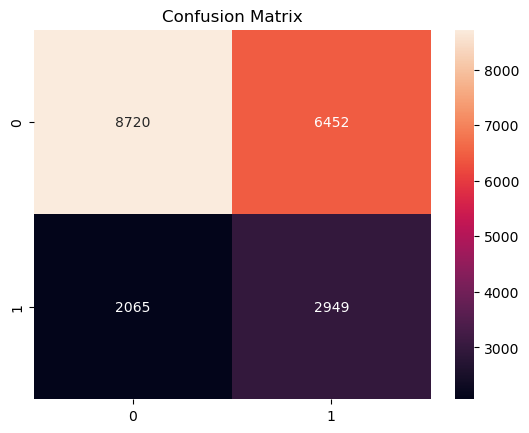

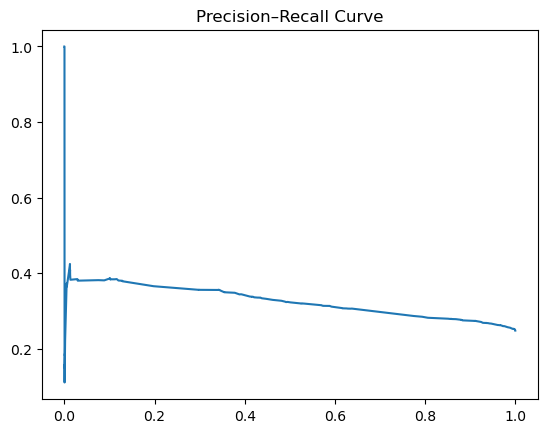

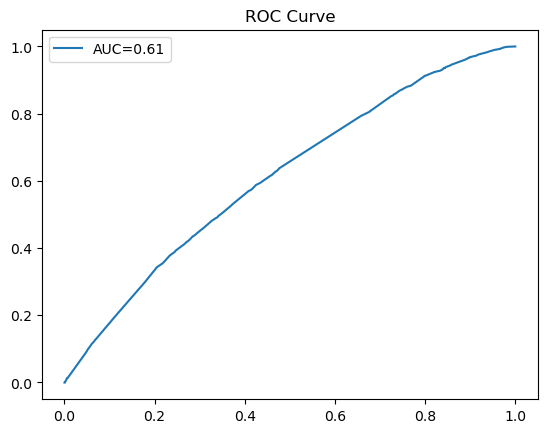

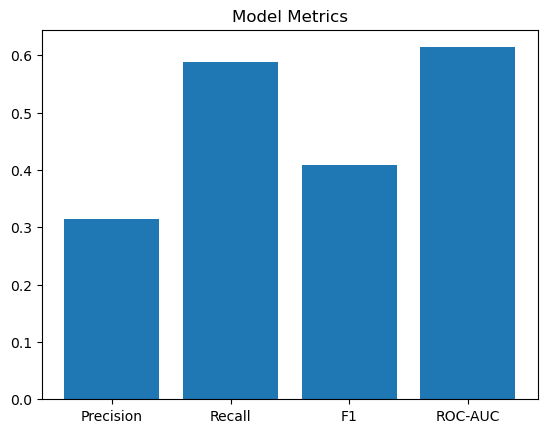

In [8]:
print("XGBoost MODEL")
print(f"Best Threshold: {best_thr:.3f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, probs)
plt.plot(rec, prec)
plt.title("Precision–Recall Curve")
plt.show()

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.title("ROC Curve")
plt.legend() 
plt.show()

metrics = {"Precision": precision_score(y_test, y_pred), "Recall": recall_score(y_test, y_pred),"F1": f1_score(y_test, y_pred),"ROC-AUC": roc_auc}
plt.bar(metrics.keys(), metrics.values())
plt.title("Model Metrics")
plt.show()

## By analysing all 4 models, and looking at the correct evaluation metric for this problem statement, that is recall and ROC-AUC value, we conclude that XGBoost is the best model 

In [25]:
probs = model.predict_proba(X_test)[:, 1]

X_test_flagged = X_test.copy()
X_test_flagged["probability"] = probs
X_test_flagged["unsafe_pred"] = (probs >= 0.5).astype(int)
X_test_flagged["actual"] = y_test.values

ranked_risks = X_test_flagged.sort_values("probability", ascending=False)

top_risks = ranked_risks[ranked_risks["unsafe_pred"] == 1][["probability","speed_limit", "is_urban","is_high_speed","has_crossing","has_traffic_control", "number_of_vehicles"]].head(10)

print("Top 10 High-Risk Infrastructure Cases:")
print(top_risks)


Top 10 High-Risk Infrastructure Cases:
       probability  speed_limit  is_urban  is_high_speed  has_crossing  \
13780     0.739916           30         1              0             0   
69928     0.716624           60         0              1             0   
93113     0.698396           60         0              1             0   
35298     0.683706           30         1              0             1   
40289     0.673895           40         1              0             1   
59514     0.672969           60         0              1             0   
37834     0.629180           30         1              0             0   
56163     0.624962           60         0              1             1   
87007     0.611221           60         0              1             1   
63610     0.611193           60         0              1             0   

       has_traffic_control  number_of_vehicles  
13780                    1                   5  
69928                    1                   6  

High‑speed rural roads (60 mph) with no crossings remain the most consistently unsafe pattern.

Urban 30–40 mph roads are also flagged when traffic volume is high and crossings are absent.

Traffic control alone is insufficient that is unsafe cases still appear even with signals or stop signs.

Multi‑vehicle collisions are a strong indicator of unsafe infrastructure, regardless of speed.

Intervention priorities should focus on:
Adding pedestrian crossings on both urban and rural roads.

Reducing speed limits or enforcing stricter speed control on rural 60 mph roads.

Managing traffic flow in urban areas with high vehicle counts.